In [2]:
import MetaTrader5 as mt
from datetime import datetime, timedelta
import pandas as pd 
import numpy as np
import time
import pytz
from discordwebhook import Discord # discordwebhook 
 

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt.__author__)
print("MetaTrader5 package version: ",mt.__version__)
print("Session Breakout Strategy: 1.0.0")
 
# =============================================
username = 55632504
password = "A1s2d3f4/"
server = "Tickmill-Live"
symbol = "GBPJPY"
lot = 0.01  # 500$ lot 0.05
discord = Discord(
    url="https://discord.com/api/webhooks/1209860197816729621/l3Urs2-z0Bqtic7lpVJK4JmwkpCzUIpFlaJb_zIM1vF_SUQW9TPHJCMPQ1ycPEpiHCNH"
)

# ===================== investic contest ========================
# Demo account number	25093532
# Demo account type	Classic
# Demo account currency	USD
# Demo account password
# hG5@4IL23uQy
# Demo account investor (read only) password
# 23E4E))nC9hX


def start_mt5(username, password, server):
    # Ensure that all variables are the correct type
    uname = int(username) # Username must be an int
    pword = str(password) # Password must be a string
    trading_server = str(server) # Server must be a string 

    # Attempt to start MT5
    if mt.initialize(login=uname, password=pword, server=trading_server):
        print("Trading Bot Starting")
        # Login to MT5
        if mt.login(login=uname, password=pword, server=trading_server):
            current_accout_info = mt.account_info()
            print('----------------------------------------')
            print(f"Login: {current_accout_info.login} \t server: {current_accout_info.server}")
            print(f"Run time: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
            print("Trading Bot Logged in and Ready to Go!")
            return True
        else:
            print("initialize() failed, error code =",mt.last_error())
            quit()
            return PermissionError
    else:
        print("MT5 Initialization Failed")
        quit()
        return ConnectionAbortedError
     
# =============================================

def discord_template(side, current_time, price, sl):
    return discord.post(
        embeds=[
            {
                "author": {
                    "name": "Session Breakout", 
                }, 
                "description": f"Open {side} GBPJPY at : {current_time} UTC",
                "fields": [
                    {"name": "Price", "value": f"{price}", "inline": False},
                    {"name": "Stop loss", "value": f"{sl}", "inline": True},
                    {"name": "Take Profit", "value": f"-", "inline": True},
                ], 
                "footer": {
                    "text": "=========================", 
                },
            }
        ],
    )

def get_data(symbol = 'GBPJPY', interval = mt.TIMEFRAME_M15, no_of_rows = 80000):
    
    rate = mt.copy_rates_from_pos(symbol, interval, 0, no_of_rows)
    columns = ["time", "open", "high", "low", "close", "tick_volume", "spread", "real_volume"]
    df = pd.DataFrame(rate, columns=columns)
    df['time'] = pd.to_datetime(df['time'], unit='s') 
    # df['time'] = df['time'] - timedelta(hours=2) # Change to tradingview time (UTC)
    
    return df

def get_session(hour):
    if 0 <= hour < 8:
        return 'asian session'
    else:
        None

def get_signal():
    
    df = get_data()  
    df['hour'] = df['time'].dt.hour
    df['session'] = df['hour'].apply(get_session)
    df['date'] = df['time'].dt.date

    df_by_date = df.groupby(['date', 'session'], as_index=False).agg(
        session_high=('high', 'max'),
        session_low=('low', 'min')
    )

    df = df.merge(df_by_date[['date','session_high','session_low']], on=['date'], how='left') 

    df['stoploss'] = df['session_high'] - (df['session_high'] - df['session_low']) / 2
    
    open_cond1 = ( df['hour'] >= 8) & (12 > df['hour'])
    
    long_cond1 = df['open'] > df['session_high'] 
    
    short_cond1 = df['open'] < df['session_low'] 
    
    close_cond1 = df['hour'] >= 17
    
    df['order_type'] = np.nan
    df['order_type'] = np.where(open_cond1 & long_cond1, 'long', df['order_type'])
    df['order_type'] = np.where(open_cond1 & short_cond1, 'short', df['order_type'])
    df['order_type'] = np.where(close_cond1 , 'close', df['order_type'])
    
    return df     

def create_position(symbol, lot, stoploss, order_type):
    
    if order_type == 'long':
        side = mt.ORDER_TYPE_BUY
        last_price = mt.symbol_info_tick(symbol).ask
        comment = 'long'
        
    elif order_type == 'short':
        side = mt.ORDER_TYPE_SELL
        last_price = mt.symbol_info_tick(symbol).bid
        comment = 'short'
        
    request = {
        "action": mt.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": side, 
        "price": last_price,
        "sl": stoploss,
        "tp": 0.0,
        "deviation": 20,
        "magic": 234000,
        "comment": comment,
        "type_time": mt.ORDER_TIME_GTC,
        "type_filling": mt.ORDER_FILLING_IOC,
    }
    ordered = mt.order_send(request)
    
    if ordered.retcode != mt.TRADE_RETCODE_DONE:
        print(f"Order execution failed with error code {ordered.retcode}: {ordered.comment}")
        
    return ordered

        
def close_position(deal_id):
    open_positions = positions_get()
    open_positions = open_positions[open_positions['ticket'] == deal_id]
    order_type  = open_positions["type"][0]
    symbol = open_positions['symbol'][0]
    volume = open_positions['volume'][0]

    if(order_type == mt.ORDER_TYPE_BUY):
        order_type = mt.ORDER_TYPE_SELL
        price = mt.symbol_info_tick(symbol).bid
    else:
        order_type = mt.ORDER_TYPE_BUY
        price = mt.symbol_info_tick(symbol).ask
	
    close_request={
        "action": mt.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": float(volume),
        "type": order_type,
        "position": deal_id,
        "price": price,
        "deviation": 20,
        "magic": 234000,
        "comment": "Close trade",
        "type_time": mt.ORDER_TIME_GTC,
        "type_filling": mt.ORDER_FILLING_IOC,
    }

    result = mt.order_send(close_request)
     
    if result.retcode != mt.TRADE_RETCODE_DONE:
        print("Failed to close order :(")
    else:
        print ("Order successfully closed!")
        
def positions_get(symbol=None):
    if(symbol is None):
	    res = mt.positions_get()
    else:
        res = mt.positions_get(symbol=symbol)

    if(res is not None and res != ()):
        df = pd.DataFrame(list(res),columns=res[0]._asdict().keys())
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    
    return pd.DataFrame()


def make_order(df, symbol, lot): 
    
    current_time = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    
    side = df.iloc[-1]['order_type']
    price = round(df.iloc[-1]['close'], 3)
    sl = round(df.iloc[-1]['stoploss'], 3)
    
    holding_position = mt.positions_get()
    num_position = len(mt.positions_get())
    
    if num_position == 0:
        
        if side == 'long':
            ordered = create_position(symbol, lot, stoploss = sl, order_type = 'long')  
            discord_template(side, current_time, price, sl)
            
        elif side == 'short':
            ordered = create_position(symbol, lot, stoploss = sl, order_type = 'short')
            discord_template(side, current_time, price, sl)
        else:
            pass       
            
    elif (num_position != 0) and (side == 'close'):  
        
        latest_pos_side = positions_get(symbol=None)['type'][0]
        latest_pos_id = positions_get(symbol=None)['ticket'][0]

        close_position(latest_pos_id)
        discord.post(content=f"Close GBPJPY at : {current_time}, \t Balance: {mt.account_info().balance} USD, \t Equity: {mt.account_info().equity} USD, \t Profit: {mt.account_info().profit}")  
            
    else:
        pass

def main(): 
    start_mt5(username, password, server)
    try:
        while True:
            
            current_time = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S') # (UTC)
            count_minute = 60-time.time()%60
            time.sleep(count_minute)
            
            df = get_signal() 
            make_order(df, symbol, lot)
            
            time.sleep(1)
            
    except Exception as error:
        print(error)
        print('=============================================')
 

ModuleNotFoundError: No module named 'MetaTrader5'

### ========= Backtest ==========

In [68]:
start_mt5(username, password, server)
df = get_signal()
 
trades = pd.DataFrame(columns=['state', 'order_type', 'open_time', 'open_price', 'close_time', 'close_price', 'session_high', 'session_low', 'stoploss'])

for i, x in df.iterrows():
    
    # open trade logic
    open_cond1 = 12 > x['hour'] >= 8
    
    num_open_trades = trades[trades['state'] == 'open'].shape[0]
    open_cond2 = num_open_trades == 0 
    if open_cond1 and open_cond2 and x['open'] > x['session_high'] : # and x['kama_fast']>x['kama_slow']
        trades.loc[len(trades), trades.columns] = ['open', 'buy', x['time'], x['open'], None, None, None, None, None]
    elif open_cond1 and open_cond2 and x['open'] < x['session_low'] :
        trades.loc[len(trades), trades.columns] = ['open', 'sell', x['time'], x['open'], None, None, None, None, None]
        
    # close trade logic
    if num_open_trades == 0:
        continue
    
    
    close_cond1 = x['hour'] >= 17
    
    open_trade_order_type = trades[trades['state'] == 'open'].iloc[0]['order_type']
    close_cond2 = x['low'] <= x['stoploss'] if open_trade_order_type == 'buy' \
                    else x['high'] >= x['stoploss'] 
                    
    if close_cond1:
        trades.loc[trades['state'] == 'open', ['state', 'close_time', 'close_price', 'session_high', 'session_low', 'stoploss']] = ['closed', x['time'], x['open'], x['session_high'], x['session_low'], x['stoploss']]
    
    if close_cond2:
        trades.loc[trades['state'] == 'open', ['state', 'close_time', 'close_price', 'session_high', 'session_low', 'stoploss']] = ['closed_sl', x['time'], x['stoploss'], x['session_high'], x['session_low'], x['stoploss']]


def calc_profit(x):
    if x['order_type'] == 'buy':
        # divide by 130 to convert to USD, 100000 is the contract size of the trade
        return (x['close_price'] - x['open_price']) # * 100000 / 130
    elif x['order_type'] == 'sell':
        return (x['open_price'] - x['close_price']) # * 100000 / 130

def calc_rmultiple(x):
    if x['order_type'] == 'buy':
        # divide by 130 to convert to USD, 100000 is the contract size of the trade
        return (x['close_price'] - x['open_price']) / abs(x['open_price'] - x['stoploss'])
    elif x['order_type'] == 'sell':
        return (x['open_price'] - x['close_price']) / abs(x['open_price'] - x['stoploss'])
    
trades['profit'] = trades.apply(calc_profit, axis=1) 
trades['return'] =  trades['profit']/trades['open_price']
trades['return'] = trades['return'].astype(float)
trades['r'] = trades.apply(calc_rmultiple, axis=1)  

Trading Bot Starting
----------------------------------------
Login: 55632504 	 server: Tickmill-Live
Run time: 2024-02-25 18:06:11
Trading Bot Logged in and Ready to Go!


In [44]:
trades

,state,order_type,open_time,open_price,close_time,close_price,session_high,session_low,stoploss,profit,return
0,closed_sl,sell,2020-12-08 10:15:00,138.708,2020-12-08 10:45:00,139.0045,139.204,138.805,139.0045,-0.2965,-0.002138
1,closed,buy,2020-12-09 08:15:00,139.429,2020-12-09 17:00:00,139.927,139.363,139.02,139.1915,0.4980,0.003572
2,closed,sell,2020-12-11 10:00:00,138.152,2020-12-11 17:00:00,137.316,138.735,138.278,138.5065,0.8360,0.006051
3,closed_sl,buy,2020-12-14 09:45:00,139.104,2020-12-14 16:15:00,138.644,139.02,138.268,138.644,-0.4600,-0.003307
4,closed_sl,sell,2020-12-15 10:45:00,138.4,2020-12-15 13:00:00,138.713,138.925,138.501,138.713,-0.3130,-0.002262
...,...,...,...,...,...,...,...,...,...,...,...
706,closed_sl,buy,2024-02-20 08:30:00,189.287,2024-02-20 13:30:00,189.101,189.277,188.925,189.101,-0.1860,-0.000983
707,closed_sl,buy,2024-02-21 09:45:00,189.534,2024-02-21 10:45:00,189.365,189.525,189.205,189.365,-0.1690,-0.000892
708,closed_sl,sell,2024-02-21 11:30:00,189.193,2024-02-21 14:00:00,189.365,189.525,189.205,189.365,-0.1720,-0.000909
709,closed_sl,buy,2024-02-22 10:00:00,190.28,2024-02-22 16:15:00,189.98,190.235,189.725,189.98,-0.3000,-0.001577


<Axes: xlabel='0', ylabel='Density'>

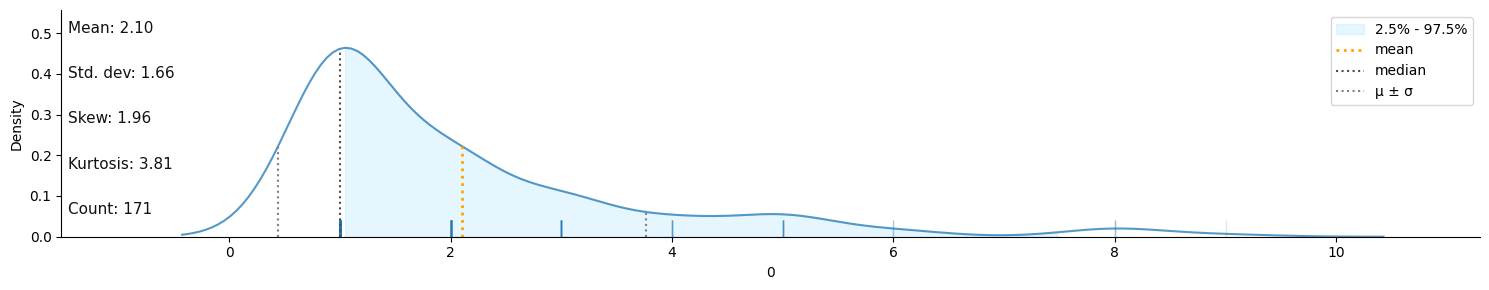

In [71]:
df = trades.copy()
# Create a column to identify consecutive losses
df['consecutive_loss'] = (df['state'] == 'closed_sl').astype(int)

# Calculate consecutive loss groups
df['consecutive_loss_group'] = (df['consecutive_loss'] != df['consecutive_loss'].shift(1)).cumsum()
# Calculate consecutive loss counts
consecutive_loss = df[df['consecutive_loss'] == 1].groupby('consecutive_loss_group').size().to_list()

klib.dist_plot(consecutive_loss)

In [72]:
df

,state,order_type,open_time,open_price,close_time,close_price,session_high,session_low,stoploss,profit,return,r,consecutive_loss,consecutive_loss_group
0,closed_sl,sell,2020-12-08 10:15:00,138.708,2020-12-08 10:45:00,139.0045,139.204,138.805,139.0045,-0.2965,-0.002138,-1.000000,1,1
1,closed,buy,2020-12-09 08:15:00,139.429,2020-12-09 17:00:00,139.927,139.363,139.02,139.1915,0.4980,0.003572,2.096842,0,2
2,closed,sell,2020-12-11 10:00:00,138.152,2020-12-11 17:00:00,137.316,138.735,138.278,138.5065,0.8360,0.006051,2.358251,0,2
3,closed_sl,buy,2020-12-14 09:45:00,139.104,2020-12-14 16:15:00,138.644,139.02,138.268,138.644,-0.4600,-0.003307,-1.000000,1,3
4,closed_sl,sell,2020-12-15 10:45:00,138.4,2020-12-15 13:00:00,138.713,138.925,138.501,138.713,-0.3130,-0.002262,-1.000000,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,closed_sl,buy,2024-02-20 08:30:00,189.287,2024-02-20 13:30:00,189.101,189.277,188.925,189.101,-0.1860,-0.000983,-1.000000,1,341
707,closed_sl,buy,2024-02-21 09:45:00,189.534,2024-02-21 10:45:00,189.365,189.525,189.205,189.365,-0.1690,-0.000892,-1.000000,1,341
708,closed_sl,sell,2024-02-21 11:30:00,189.193,2024-02-21 14:00:00,189.365,189.525,189.205,189.365,-0.1720,-0.000909,-1.000000,1,341
709,closed_sl,buy,2024-02-22 10:00:00,190.28,2024-02-22 16:15:00,189.98,190.235,189.725,189.98,-0.3000,-0.001577,-1.000000,1,341


In [24]:
trades_buy = trades[trades['order_type']=='buy']
trades_buy['open_price_dif_session_high'] = (trades_buy['open_price'] - trades_buy['session_high'])/trades_buy['session_high']

import plotly.express as px 
fig = px.scatter(trades_buy, x="return", y="open_price_dif_session_high", color="state")
fig.show()

Start date,2020-12-08
End date,2024-02-23
Total months,33
,Backtest
Annual return,5.753%
Cumulative returns,17.097%
Annual volatility,5.091%
Sharpe ratio,1.12
Calmar ratio,1.27
Stability,0.91
Max drawdown,-4.548%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.55,2022-09-16,2022-12-22,2023-02-22,114
1,2.90,2022-02-10,2022-03-18,2022-05-18,70
2,2.67,2023-09-08,2023-10-26,2023-12-11,67
3,2.53,2023-02-28,2023-07-06,2023-08-16,122
4,2.01,2021-02-25,2021-05-26,2021-07-19,103


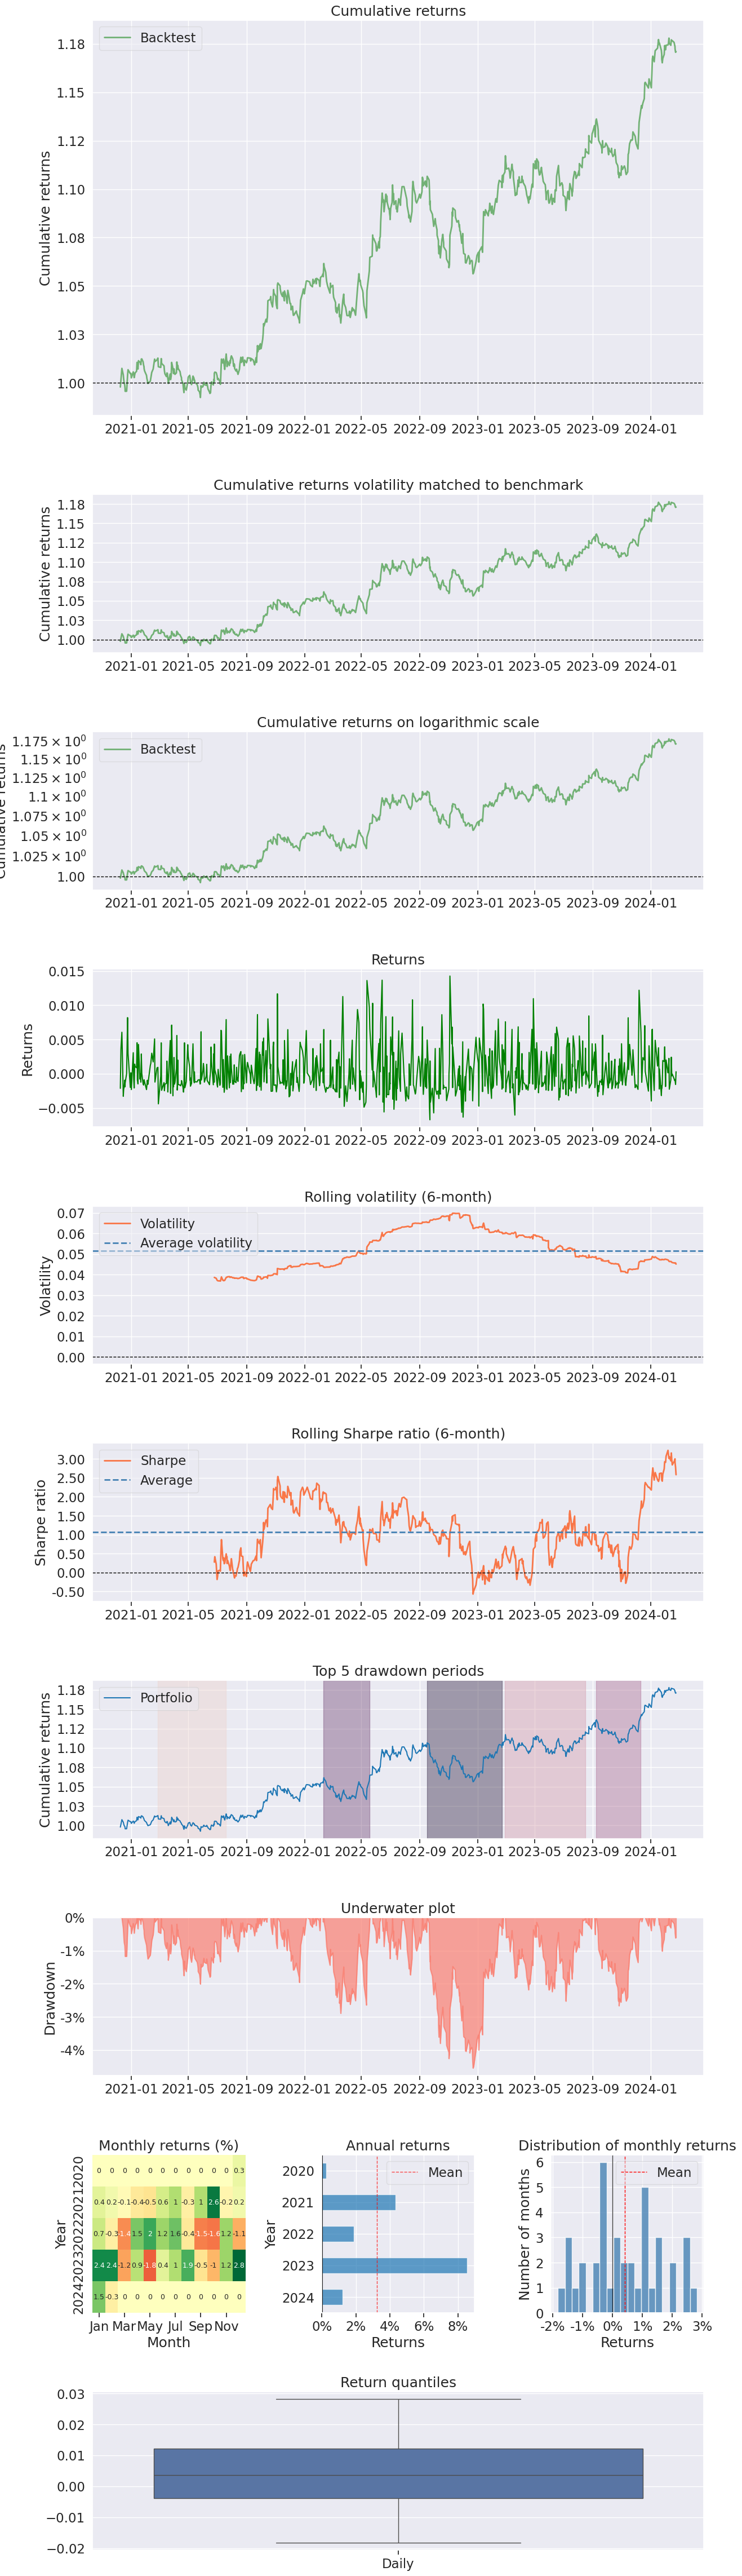

In [48]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')
pf.create_returns_tear_sheet(trades.set_index('close_time')['return'] )

Start date,2023-09-28
End date,2024-02-21
Total months,4
,Backtest
Annual return,13.835%
Cumulative returns,4.414%
Annual volatility,4.579%
Sharpe ratio,2.85
Calmar ratio,8.24
Stability,0.81
Max drawdown,-1.679%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.68,2023-09-28,2023-10-26,2023-11-20,38
1,1.02,2024-01-17,2024-01-25,2024-02-08,17
2,0.78,2023-11-24,2023-12-05,2023-12-07,10
3,0.46,2024-02-08,2024-02-21,NaT,NaN
4,0.40,2023-12-28,2024-01-02,2024-01-03,5


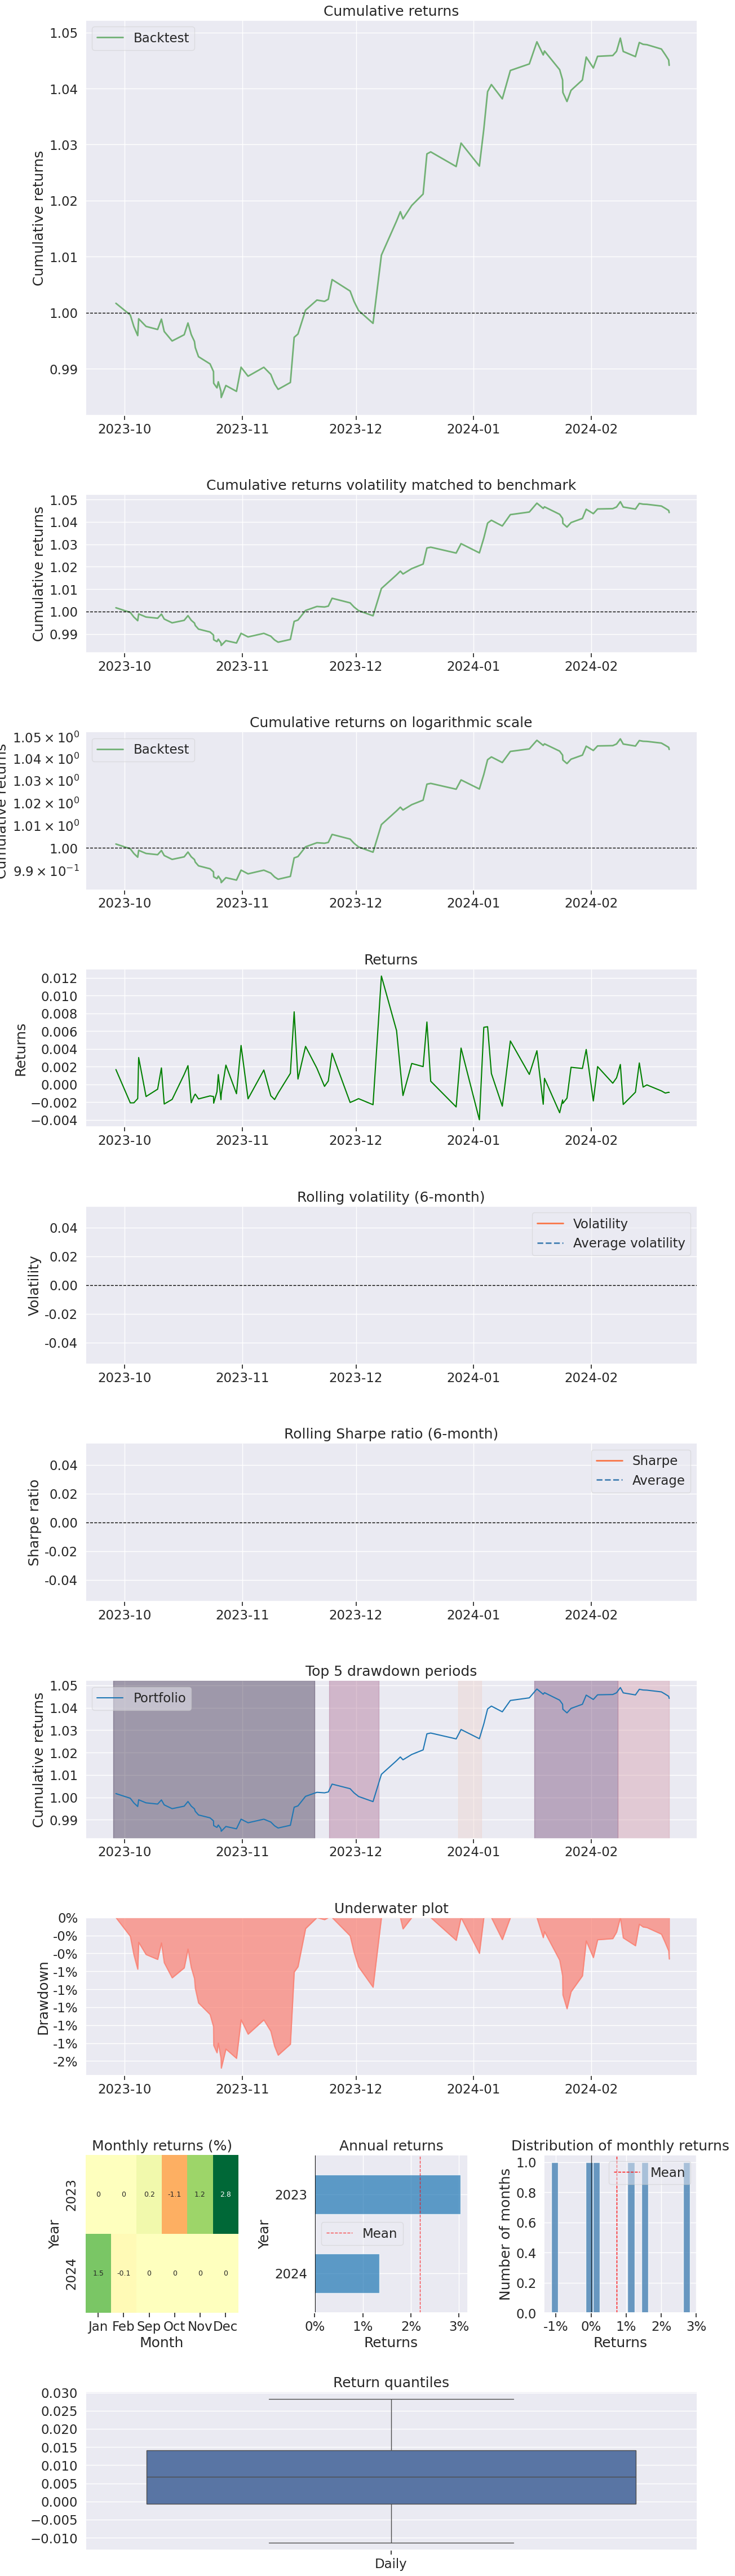

In [8]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')
pf.create_returns_tear_sheet(trades.set_index('close_time')['return'] )